<a href="https://colab.research.google.com/github/mizuociwame/gan/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# hyper params
iteration = 67000
batchsize = 16

# extension params
snapshot_interval = iteration//10
display_interval = iteration//100
update_interval = display_interval
log_interval = iteration//1000

# model params
sa_gamma = 1.
gen_noise = 0.1
sa_increment = False

# learning controller
learning_rate = 1e-4
grad_clip = False
dump_graph = False
load_weight = True
load_opt = True
phase = 0
IMG_SHAPE = (128, 128)
GPU = 0

''' phase
0- : all decoder training.
1- : trans encoding.(hold)
'''

# file names
mount = './'
OUT = mount+'/Drive_sync/result/'
dataset = mount+'/Drive_sync/picture/train_pic/**/*.jpg'
generator_name = 'korosu_gen'
dis_gen_name = 'korosu_dis_gen'
cri_ae_name = 'korosu_cri_ae'
opt_generator_name = 'korosu_opt_gen'
opt_dis_gen_name = 'korosu_opt_dis_gen'
opt_cri_ae_name = 'korosu_opt_cri_ae'
graph = 'korosu_graph'

In [0]:
import numpy
import math
import glob
from PIL import Image, ImageOps, ImageChops, ImageFilter
import matplotlib.pyplot as plt
import cupy

import chainer
from chainer import training, backend, Variable
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
import chainer.backends.cuda
import chainer.link_hooks as LH

from IPython.display import clear_output

7.4.0


/home/hina/anaconda3/envs/colab/lib/python3.7/site-packages/chainer/_environment_check.py:73: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy) version 6.0.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy>=6.3.0,<7.0.0'

See the following page for more details:
  https://docs-cupy.chainer.org/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


In [0]:
def make_optimizer_Adam(model, alpha=1e-4, beta1=0.5, clip=True):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    if clip:
        optimizer.add_hook(chainer.optimizer_hooks.GradientClipping(1.))
    return optimizer

In [0]:
def gaussian(size):
    return F.gaussian(cupy.zeros(size, dtype=cupy.float32),
                     cupy.ones(size, dtype=cupy.float32))
    
def zeropad(x, ch):
    return F.pad(x, ((0, 0), (0, ch-x.shape[1]), (0, 0), (0, 0)), 'constant', constant_values=0)

def gap(x):
    return F.average_pooling_2d(x, x.shape[-2:])
    
def noise_injection(x, k):
    return F.gaussian(x, cupy.ones(x.shape, dtype=cupy.float32)*k)

def upsample(x):
    return F.depth2space(x, 2)

def gram(x):
    _x = F.reshape(x, (x.shape[:2]+(-1,)))
    _x = F.batch_matmul(_x, _x, transb=True)/_x.shape[-1]
    return _x

def style_matching(x1, x2):
    return F.mean_squared_error(gram(x1), gram(x2))

def earthmover_distance(x1, x2):
    x1_means = F.mean(x1.T, axis=1)
    x2_means = F.mean(x2.T, axis=1)
    emd = F.mean(x1_means - x2_means)
    return emd

In [0]:
def out_generated_image(gen, c_iter, v_iter):
    @chainer.training.make_extension()
    def make_image(trainer):
        clear_output()
        xp = gen.xp
        c_base = xp.asarray(c_iter.next())
        z_c = Variable(c_base[:,1])/255. *2. -1.
        if phase < 1:
            v_base = c_base[:,0]
        else:
            v_base = xp.asarray(v_iter.next())[:,0]
        z_v = Variable(v_base)/255. *2. -1.
        
        with chainer.using_config('train', False):
            x, zs = gen(z_c, z_v)
            
        x = F.transpose(F.reshape(x, (-1, 3)+IMG_SHAPE), (0, 2, 3, 1))
        x = chainer.backends.cuda.to_cpu(x.array)
        zs = chainer.backends.cuda.to_cpu(zs.array)
        
        plt.figure(figsize=(16, 16))
        
        for i, img in enumerate(xp.asnumpy(c_base[:,1])):
            plt.subplot(4, 4, i+1).axis('off')
            plt.subplot(4, 4, i+1).imshow(Image.fromarray(numpy.uint8(img).transpose((1, 2, 0))))
            
        for i, img in enumerate(x):
            plt.subplot(4, 4, i+5).axis('off')
            plt.subplot(4, 4, i+5).imshow(Image.fromarray(numpy.uint8((img+1.)/2. *255.)))

        ax = plt.subplot2grid((4, 4), (2, 0), colspan=4)
        for i, zs in enumerate(zs):
            ax.plot(zs,
                    marker='.',
                    linestyle='None',
                    label='z({})'.format(i),
                    color='rgbk'[i])
            ax.legend()
            
        for i, img in enumerate(xp.asnumpy(v_base)):
            plt.subplot(4, 4, i+13).axis('off')
            plt.subplot(4, 4, i+13).imshow(Image.fromarray(numpy.uint8(img).transpose((1, 2, 0))))
        
        plt.show()
    return make_image

In [0]:
class Conv(chainer.Chain):
    def __init__(self, ch, kernel=1, stride=1, padding=0,wscale=1.):
        super(Conv, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.c = L.Convolution2D(None, ch, kernel, stride, padding, initialW=w).add_hook(LH.SpectralNormalization())
    
    def __call__(self, x):
        h = F.leaky_relu(x)
        h = self.c(h)
        return h

In [0]:
class DepthwiseConv(chainer.Chain):
    def __init__(self, ch, kernel=3, stride=1, padding=1,wscale=1.):
        super(DepthwiseConv, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.c = L.Convolution2D(None, ch, 1, 1, 0, initialW=w).add_hook(LH.SpectralNormalization())
            self.dc = L.DepthwiseConvolution2D(None, 1, kernel, stride, padding, initialW=w).add_hook(LH.SpectralNormalization())
    
    def __call__(self, x):
        h = F.leaky_relu(x)
        h = self.c(h)
        h = F.leaky_relu(h)
        h = self.dc(h)
        return h

In [0]:
class SelfAttentionBlock(chainer.Chain):
    def __init__(self, ch, wscale=1., gamma=1.):
        super(SelfAttentionBlock, self).__init__()

        self.gamma = gamma
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.cf = Conv(ch*3//16)
            self.cg = Conv(ch*3//16)
            self.ch = Conv(ch*3//2)
            
    def __call__(self, x):
        f = self.cf(x)
        g = self.cg(x)
        h = self.ch(x)
        f = F.reshape(f, f.shape[:2]+(-1,))
        g = F.reshape(g, g.shape[:2]+(-1,))
        h = F.reshape(h, h.shape[:2]+(-1,))
        
        attention_map = F.batch_matmul(f, g, transa=True)
        attention_map = F.softmax(attention_map, axis=-1)
        feature_map = F.batch_matmul(h, attention_map, transb=True)
        feature_map = F.reshape(feature_map, x.shape)
        return F.add(x, feature_map*self.gamma)

    def set_gamma(self, gamma):
        self.gamma = gamma

In [0]:
class InceptionBlock(chainer.Chain):
    def __init__(self, in_ch, out_ch, wscale=1.):
        super(InceptionBlock, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.layer_11 = Conv(in_ch)
            self.layer_31 = DepthwiseConv(in_ch, (3,1), 1, (1,0))
            self.layer_13 = DepthwiseConv(in_ch, (1,3), 1, (0,1))
            self.layer_33 = DepthwiseConv(in_ch, 3, 1, 1)
            self.layer_51 = DepthwiseConv(in_ch, (5,1), 1, (2,0))
            self.layer_15 = DepthwiseConv(in_ch, (1,5), 1, (0,2))
            self.layer_55 = DepthwiseConv(in_ch, 5, 1, 2)

            self.c = Conv(out_ch)
            
    def __call__(self, x):
        h_11 = self.layer_11(x)
        h_31 = self.layer_31(x)
        h_13 = self.layer_13(x)
        h_33 = self.layer_33(x)
        h_51 = self.layer_51(x)
        h_15 = self.layer_15(x)
        h_55 = self.layer_55(x)
        
        h = F.concat((h_11, h_31, h_13, h_33, h_51, h_15, h_55))
        h = self.c(h)
        return h

In [0]:
class LargeInceptionBlock(chainer.Chain):
    def __init__(self, in_ch, out_ch, wscale=1.):
        super(LargeInceptionBlock, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.layer_33 = DepthwiseConv(in_ch, 3, 1, 1)
            self.layer_51 = DepthwiseConv(in_ch, (5,1), 1, (2,0))
            self.layer_15 = DepthwiseConv(in_ch, (1,5), 1, (0,2))
            self.layer_55 = DepthwiseConv(in_ch, 5, 1, 2)
            self.layer_71 = DepthwiseConv(in_ch, (7,1), 1, (3,0))
            self.layer_17 = DepthwiseConv(in_ch, (1,7), 1, (0,3))
            self.layer_77 = DepthwiseConv(in_ch, 7, 1, 3)

            self.c = Conv(out_ch)
            
    def __call__(self, x):
        h_33 = self.layer_33(x)
        h_51 = self.layer_51(x)
        h_15 = self.layer_15(x)
        h_55 = self.layer_55(x)
        h_71 = self.layer_71(x)
        h_17 = self.layer_17(x)
        h_77 = self.layer_77(x)
        
        h = F.concat((h_33, h_51, h_15, h_55, h_71, h_17, h_77))
        h = self.c(h)
        return h

In [0]:
class ResBlock(chainer.Chain):
    def __init__(self, ch, k=8, wscale=1., upsample=False):
        super(ResBlock, self).__init__()
        self.ch = ch
        in_ch = self.ch//k

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.inception_1 = LargeInceptionBlock(in_ch, self.ch) if upsample else InceptionBlock(in_ch, self.ch)
            self.inception_2 = InceptionBlock(in_ch*3//2, self.ch*3//2)
            
    def __call__(self, x, injection=False, noise=0):
        _h = self.inception_1(x)
        h = zeropad(x, self.ch)
        h = h + _h
        _h = noise_injection(h, noise) if injection else h
        _h = self.inception_2(_h)
        h = zeropad(h, self.ch*3//2)
        h = h + _h
        return h

In [0]:
class Dense(chainer.Chain):
    def __init__(self, ch, wscale=1.):
        super(Dense, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.l = L.Linear(None, ch, initialW=w).add_hook(LH.SpectralNormalization())

    def __call__(self, x):
        h = F.leaky_relu(x)
        h = self.l(h)
        return h

In [0]:
class Affine(chainer.Chain):
    def __init__(self, ch, mid1=512, mid2=512, wscale=1.):
        super(Affine, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.l1 = Dense(mid1, wscale=wscale)
            self.l2 = Dense(mid2, wscale=wscale)
            self.l_out = Dense(ch, wscale=wscale)

    def __call__(self, x):
        h = self.l1(x)
        h = self.l2(h)
        h = self.l_out(h)
        return h

In [0]:
class Downsample(chainer.Chain):
    def __init__(self, wscale=1.):
        super(Downsample, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.mid = Dense(4)
            
    def __call__(self, x):
        b, c, h, w = x.shape
        _x = F.reshape(x, (b, c, h//2, 2, w//2, 2))
        _x = F.transpose(_x, (0, 1, 2, 4, 3, 5))
        _x = F.reshape(_x, (-1, 4))
        excite = F.sigmoid(self.mid(_x))
        _x = F.sum(_x*excite, axis=1)
        return F.reshape(_x, (b, c, h//2, w//2))

In [0]:
class MinibatchDiscrimination(chainer.Chain):
    def __init__(self, kernel, ch, wscale=1.):
        super(MinibatchDiscrimination, self).__init__()
        self.kernel = kernel
        self.ch = ch
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.t = L.Linear(None, self.kernel*self.ch, initialW=w).add_hook(LH.SpectralNormalization())

    def __call__(self, x):
        batchsize = x.shape[0]
        m = F.reshape(self.t(x), (batchsize, self.kernel, self.ch))
        m = F.expand_dims(m, 3)
        m_T = F.transpose(m, (3, 1, 2, 0))
        m, m_T = F.broadcast(m, m_T)
        norm = F.sum(F.absolute_error(m, m_T), axis=2)
        eraser = F.broadcast_to(cupy.eye(batchsize, dtype=cupy.float32).reshape((batchsize, 1, batchsize)), norm.shape)
        c_b = F.exp(-(norm + 1e6 * eraser))
        o_b = F.sum(c_b, axis=2)
        h = F.concat((x, o_b))
        return h

In [0]:
class DiscriminatorGen(chainer.Chain):

    def __init__(self, wscale=1., sa_gamma=1.):
        super(DiscriminatorGen, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.c_in = L.Convolution2D(3, 64, 1, 1, 0, initialW=w).add_hook(LH.SpectralNormalization())
            
            self.res0 = ResBlock(64)
            self.res1 = ResBlock(128)
            self.res2 = ResBlock(256)

            self.res3 = ResBlock(512)
            self.sa3 = SelfAttentionBlock(512, gamma=sa_gamma)

            self.res4 = ResBlock(1024)
            self.sa4 = SelfAttentionBlock(1024, gamma=sa_gamma)

            self.resize = Downsample()

            self.l_m = Affine(512)
            self.minibatch_discrimination = MinibatchDiscrimination(64, 16)

            self.l_out = Dense(1)
    
    def __call__(self, z):
        x = self.c_in(z)
        x = self.res0(x)
        # 128
        
        x = self.resize(x)
        x = self.res1(x)
        # 64
        
        x = self.resize(x)
        x = self.res2(x)
        # 32
        
        x = self.resize(x)
        x = self.res3(x)
        x = self.sa3(x)
        # 16
        
        x = self.resize(x)
        x = self.res4(x)
        x = self.sa4(x)
        # 8
        
        x = gap(x)
        h_m = self.l_m(x)
        x = self.minibatch_discrimination(h_m)
        x = self.l_out(x)
        return x, h_m

    def set_gamma(self, gamma):
        self.sa3.set_gamma(gamma)
        self.sa4.set_gamma(gamma)

In [0]:
class CriticAE(chainer.Chain):

    def __init__(self, wscale=1e-2):
        super(CriticAE, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.l_in = L.Linear(None, 1024, initialW=w).add_hook(LH.SpectralNormalization())
            self.l_mid = Affine(128, 512, 256, wscale=wscale)
            self.minibatch_discrimination = MinibatchDiscrimination(64, 16, wscale=wscale)
            self.l_out = Dense(16, wscale=wscale)

    def __call__(self, z):
        batchsize = z.shape[0]

        h = self.l_in(z)
        h = self.l_mid(h)
        h = self.minibatch_discrimination(h)
        h = self.l_out(h)
        return h

In [0]:
class Encode(chainer.Chain):

    def __init__(self, ch, wscale=1., sa_gamma=1.):
        super(Encode, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.c_in = L.Convolution2D(3, 64, 1, 1, 0, initialW=w).add_hook(LH.SpectralNormalization())
            
            self.res0 = ResBlock(64)
            self.res1 = ResBlock(128)
            self.res2 = ResBlock(256)

            self.res3 = ResBlock(512)
            self.sa3 = SelfAttentionBlock(512, gamma=sa_gamma)

            self.res4 = ResBlock(1024)
            self.sa4 = SelfAttentionBlock(1024, gamma=sa_gamma)

            self.resize = Downsample()

            self.out = Affine(ch)
    
    def __call__(self, x):
        z = self.c_in(F.leaky_relu(x))
        z = self.res0(z)
        # 128
        
        z = self.resize(z)
        z = self.res1(z)
        # 64
        
        z = self.resize(z)
        z_32 = self.res2(z)
        # 32
        
        z = self.resize(z_32)
        z = self.res3(z)
        z = self.sa3(z)
        # 16
        
        z = self.resize(z)
        z = self.res4(z)
        z = self.sa4(z)
        # 8
        
        z = gap(z)
        z = self.out(z)
        return z

    def set_gamma(self, gamma):
        self.sa3.set_gamma(gamma)
        self.sa4.set_gamma(gamma)

In [0]:
class Segment(chainer.Chain):

    def __init__(self, wscale=1., sa_gamma=1.):
        super(Segment, self).__init__()

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.c_in = L.Convolution2D(3, 64, 1, 1, 0, initialW=w).add_hook(LH.SpectralNormalization())
            self.down0 = ResBlock(64, 16)
            self.down1 = ResBlock(128, 16)
            self.down2 = ResBlock(256, 16)

            self.down3 = ResBlock(512, 16)
            self.sa3 = SelfAttentionBlock(512, gamma=sa_gamma)

            self.down4 = ResBlock(1024, 16)
            self.sa4 = SelfAttentionBlock(1024, gamma=sa_gamma)
            
            self.up0 = ResBlock(64, upsample=True)
            self.up1 = ResBlock(128, upsample=True)
            self.up2 = ResBlock(256, upsample=True)
            self.up3 = ResBlock(512, upsample=True)

            self.resize = Downsample()
    
    def __call__(self, x):
        f_128 = self.c_in(x)
        f_128 = self.down0(f_128)
        # 128

        f = self.resize(f_128)
        f_64 = self.down1(f)
        # 64

        f = self.resize(f_64)
        f_32= self.down2(f)
        # 32

        f = self.resize(f_32)
        f= self.down3(f)
        f_16 = self.sa3(f)
        # 16

        f = self.resize(f_16)
        f = self.down4(f)
        f_8 = self.sa4(f)
        # 8

        f = self.up3(upsample(f_8))
        f_16 = F.add(f_16, f)
        # 16

        f = self.up2(upsample(f_16))
        f_32 = F.add(f_32, f)
        # 32

        f = self.up1(upsample(f_32))
        f_64 = F.add(f_64, f)
        # 64

        f = self.up0(upsample(f_64))
        f_128 = F.add(f_128, f)
        # 128

        return f_8, f_16, f_32, f_64, f_128
            
    def set_gamma(self, gamma):
        self.sa3.set_gamma(gamma)
        self.sa4.set_gamma(gamma)

In [0]:
class TXSegmentBlock(chainer.Chain):
    def __init__(self, ch, wscale=1.):
        super(TXSegmentBlock, self).__init__()
        
        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            self.bias = Conv(ch*3//2)
            self.gamma = Conv(ch*3//2)
            
    def __call__(self, x, s):
        g = F.sigmoid(self.gamma(s))
        b = self.bias(s)
        
        h = x*g + b
        return h

In [0]:
class Generator(chainer.Chain):

    def __init__(self, wscale=1., sa_gamma=1., noise=0):
        super(Generator, self).__init__()
        self.noise = noise

        with self.init_scope():
            w = chainer.initializers.HeNormal(wscale)
            
            self.txencode = Encode(512, sa_gamma=sa_gamma)
            self.segment = Segment(sa_gamma=sa_gamma)
            
            self.txbtm = L.Linear(None, 1024*8*8, initialW=w).add_hook(LH.SpectralNormalization())
            
            self.res5 = ResBlock(1024)
            self.seg_8 = TXSegmentBlock(1024)
            
            self.res4 = ResBlock(512, upsample=True)
            self.seg_16 = TXSegmentBlock(512)
            
            self.res3 = ResBlock(256, upsample=True)
            self.seg_32 = TXSegmentBlock(256)
            
            self.res2 = ResBlock(128, upsample=True)
            self.seg_64 = TXSegmentBlock(128)
            
            self.res1 = ResBlock(64, upsample=True)
            self.seg_128 = TXSegmentBlock(64)
            
            self.c_out = Conv(3)
    
    def __call__(self, x, style):
        z = self.txencode(style)
        s_8, s_16, s_32, s_64, s_128 = self.segment(x)
        
        h = F.reshape(self.txbtm(z), (-1, 1024, 8, 8))
        h = self.res5(h, True, self.noise)
        h = self.seg_8(h, s_8)
        # 8
        
        h = upsample(h)
        h = self.res4(h, True, self.noise)
        h = self.seg_16(h, s_16)
        # 16
        
        h = upsample(h)
        h = self.res3(h, True, self.noise)
        h = self.seg_32(h, s_32)
        # 32
        
        h = upsample(h)
        h = self.res2(h, True, self.noise)
        h = self.seg_64(h, s_64)
        # 64
        
        h = upsample(h)
        h = self.res1(h, True, self.noise)
        h = self.seg_128(h, s_128)
        # 128
        
        h = F.tanh(self.c_out(h))
        # 128
        return h, z

    def set_gamma(self, gamma):
        self.txencode.set_gamma(gamma)
        self.segment.set_gamma(gamma)

In [0]:
class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, end_point, sa_increment, sa_gamma, *args, **kwargs):
        self.end_point = end_point
        self.sa_increment = sa_increment
        self.sa_gamma = sa_gamma
        self.gen, self.dis_gen, self.cri_ae = kwargs.pop('models')
        super(DCGANUpdater, self).__init__(*args, **kwargs)

    def set_gamma(self, gamma):
        self.gen.set_gamma(gamma)
        self.dis_gen.set_gamma(gamma)

    def loss_dis(self, dis, loss, opt):
        chainer.report({opt: loss}, dis)
        return loss
    
    def loss_gen(self, gen, losses):
        loss = F.sum(losses) 
        chainer.report({'loss': loss,
                        'fake': losses[0],
                        'fm': losses[1],
                        'rec': losses[2],
                        'z': losses[-1]}, gen)
        return loss

    def update_core(self):
        gen_optimizer = self.get_optimizer('gen')
        dis_gen_optimizer = self.get_optimizer('dis_gen')
        cri_ae_optimizer = self.get_optimizer('cri_ae')
        
        if self.sa_increment:
            gamma = self.sa_gamma*self.iteration/self.end_point
            self.set_gamma(gamma)

        gen, dis_gen, cri_ae = self.gen, self.dis_gen, self.cri_ae
        main_iter = self.get_iterator('main')
        style_iter = self.get_iterator('style')
        
        batch_c = main_iter.next()
        batchsize = len(batch_c)
        x_c = Variable(self.converter(batch_c, device=self.device)) /255. *2. -1.
        x_c_real = x_c[:,0]
        x_c_base = x_c[:,1]
        x_v_real = x_c[:,2]

        if phase >= 1:
            batch_v = style_iter.next()
            x_v_real = Variable(self.converter(batch_v, device=self.device))[:,0] /255. *2. -1.
        
        if phase < 1:
            x_fake, z = gen(x_c_base, x_c_real)             
            y_real, fm_real = dis_gen(x_c_real)
        else:
            x_fake, z = gen(x_c_base, x_v_real)   
            y_real, fm_real = dis_gen(x_v_real)
            
        dis_loss_real = F.mean((y_real-1)**2)
        dis_gen_optimizer.update(self.loss_dis, dis_gen, dis_loss_real, 'real')
        
        y_fake, fm_fake = dis_gen(x_fake)
        dis_loss_fake = F.mean(y_fake**2)
        dis_gen_optimizer.update(self.loss_dis, dis_gen, dis_loss_fake, 'fake')

        fake_loss = F.mean((y_fake-1)**2)
        fm_loss = F.mean_squared_error(fm_real, fm_fake)*10
        if phase < 1:
            reconst_loss = F.mean_squared_error(x_v_real, x_fake)*10
        else:
            reconst_loss = F.mean_squared_error(x_c_base, x_fake)*5
        
        z_real = cri_ae(gaussian(z.shape))
        z_fake = cri_ae(z)
        
        ae_real_loss = -earthmover_distance(z_real, z_fake)
        cri_ae_optimizer.update(self.loss_dis, cri_ae, ae_real_loss, 'ae_real')

        z_loss = -F.mean(z_fake)

        gen_optimizer.update(self.loss_gen, gen, F.stack((
            fake_loss, 
            fm_loss,
            reconst_loss,
            z_loss)))

In [0]:
gen = Generator(sa_gamma=sa_gamma, noise=gen_noise)
dis_gen = DiscriminatorGen(sa_gamma=sa_gamma)
cri_ae = CriticAE()

In [0]:
chainer.backends.cuda.get_device_from_id(GPU).use()
gen.to_gpu()
dis_gen.to_gpu()
cri_ae.to_gpu()

In [0]:
opt_gen = make_optimizer_Adam(gen, alpha=learning_rate, clip=grad_clip)
opt_dis_gen = make_optimizer_Adam(dis_gen, alpha=learning_rate, clip=grad_clip)
opt_cri_ae = make_optimizer_Adam(cri_ae, alpha=learning_rate, clip=grad_clip)

In [0]:
if load_weight:
    chainer.serializers.load_npz(OUT+generator_name+'.npz', gen,)
    chainer.serializers.load_npz(OUT+dis_gen_name+'.npz', dis_gen)
    chainer.serializers.load_npz(OUT+cri_ae_name+'.npz', cri_ae)
if load_opt:
    chainer.serializers.load_npz(OUT+opt_generator_name+'.npz', opt_gen)
    chainer.serializers.load_npz(OUT+opt_dis_gen_name+'.npz', opt_dis_gen)
    chainer.serializers.load_npz(OUT+opt_cri_ae_name+'.npz', opt_cri_ae)

In [0]:
def crop_sq(img):
    img_width, img_height = img.size
    sub = img_width - img_height
    if sub == 0:
        return img
    crop_size = min(img.size)
    crop_position = numpy.random.randint(0, abs(sub))
    if sub > 0:
        return img.crop((crop_position, 0, crop_size+crop_position, crop_size))
    else:
        return img.crop((0, crop_position, crop_size, crop_size+crop_position))

In [0]:
def img_convert(img_array):
    img = Image.fromarray(numpy.uint8(img_array.transpose(1, 2, 0))).convert('RGB')
    image_trans_trigger = numpy.random.randn(2)
    
    real_img = crop_sq(img)
    base_real_img = crop_sq(img)
        
    if image_trans_trigger[0] > 0:
        real_img = ImageOps.mirror(real_img)
        
    if image_trans_trigger[1] > 0:
        real_img = real_img.resize(IMG_SHAPE)
    else:
        real_img = real_img.resize((IMG_SHAPE[0]+IMG_SHAPE[0]//8, IMG_SHAPE[1]+IMG_SHAPE[1]//8))
        crop_position = numpy.random.randint(0, IMG_SHAPE[0]//8, 2)
        real_img = real_img.crop((crop_position[0],
                                  crop_position[1],
                                  crop_position[0]+IMG_SHAPE[0],
                                  crop_position[1]+IMG_SHAPE[1]))

    real_array = numpy.asarray(real_img, dtype=numpy.float32).transpose(2, 0, 1)
        
    base_real_img = base_real_img.resize(IMG_SHAPE)
    base_img = base_real_img
    base_real_img = numpy.asarray(base_real_img, dtype=numpy.float32).transpose(2, 0, 1)

    base_img = base_img.filter(ImageFilter.GaussianBlur(1.0))
    base_img = base_img.filter(ImageFilter.SMOOTH_MORE)

    quantize_size = numpy.random.randint(4, 17)
    base_img = base_img.quantize(quantize_size, kmeans=True).convert('RGB')
    
    base_array = numpy.asarray(base_img, dtype=numpy.float32).transpose(2, 0, 1)
    
    out_array = numpy.concatenate((real_array[None, :, :, :],
                                   base_array[None, :, :, :],
                                   base_real_img[None, :, :, :]), axis=0)
    return out_array

In [0]:
image_files = glob.glob(dataset, recursive=True)
print('{} contains {} image files'
      .format(dataset, len(image_files)))
img_dataset = chainer.datasets.ImageDataset(paths=image_files)

train = chainer.datasets.TransformDataset(img_dataset, img_convert)
sample = chainer.datasets.TransformDataset(img_dataset, img_convert)

.//Drive_sync/picture/train_pic/**/*.jpg contains 1062026 image files


In [0]:
train_c_iter = chainer.iterators.SerialIterator(train, batchsize, shuffle=True)
train_v_iter = chainer.iterators.SerialIterator(train, batchsize, shuffle=True)

In [0]:
updater = DCGANUpdater(
    end_point=iteration,
    sa_increment=sa_increment,
    sa_gamma=sa_gamma,
    models=(gen, dis_gen, cri_ae),
    iterator={'main': train_v_iter, 'style': train_c_iter},
    optimizer={'gen': opt_gen, 'dis_gen': opt_dis_gen, 'cri_ae': opt_cri_ae},
    device=GPU)

In [0]:
trainer = training.Trainer(updater, (iteration, 'iteration'), out=OUT)

In [0]:
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')
log_interval = (log_interval, 'iteration')

In [0]:
if dump_graph:
    trainer.extend(extensions.DumpGraph('gen/fake', graph+'.dot'))
    
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(out_generated_image(gen,
                                   chainer.iterators.SerialIterator(sample, 4, shuffle=True),
                                   chainer.iterators.SerialIterator(sample, 4, shuffle=True)),
               trigger=display_interval)
trainer.extend(extensions.ProgressBar(update_interval=update_interval))
trainer.extend(extensions.snapshot_object(gen, generator_name+'.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(dis_gen, dis_gen_name+'.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(cri_ae, cri_ae_name+'.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(opt_gen, opt_generator_name+'.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(opt_dis_gen, opt_dis_gen_name+'.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(opt_cri_ae, opt_cri_ae_name+'.npz'), trigger=snapshot_interval)
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration', 'dis_gen/real', 'gen/loss', 'gen/fake', 'gen/fm', 'gen/rec', 'gen/z'
    ]), trigger=display_interval)

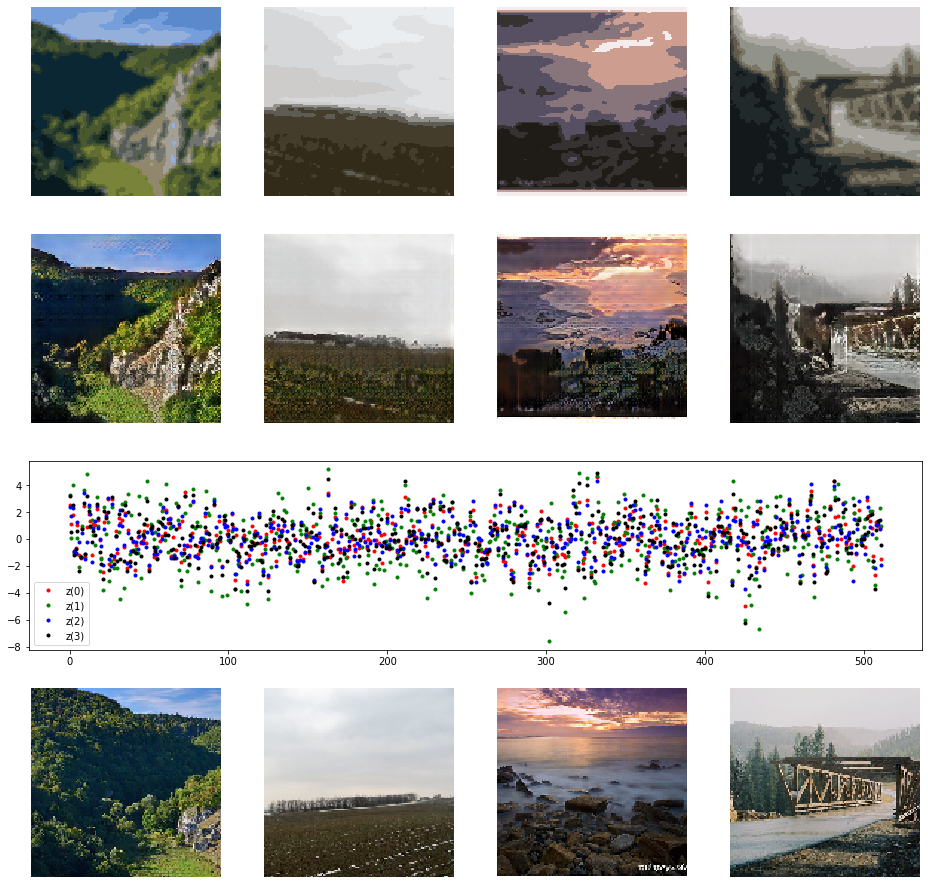

     total [####..............................................]  9.00%
this epoch [####..............................................]  9.08%
      6030 iter, 0 epoch / 67000 iterations
   0.18419 iters/sec. Estimated time to finish: 3 days, 19:57:02.540937.
0           5427        0.151101      3.17979     0.540466    0.0183962   0.551255    2.06967     
0           5494        0.137698      7.95336     0.549334    0.019102    0.604783    6.78014     
0           5561        0.134648      4.3073      0.546575    0.018539    0.597296    3.14489     
0           5628        0.159418      0.972488    0.545292    0.0213575   0.545988    -0.140148   
0           5695        0.135169      3.38272     0.59615     0.0231355   0.59727     2.16617     
0           5762        0.145083      4.44942     0.601992    0.020757    0.589686    3.23699     
0           5829        0.124599      4.1998      0.652051    0.0246346   0.598233    2.92489     
0           5896        0.154211      5.18131   

In [0]:
trainer.run()